In [18]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Project root added to sys.path:", PROJECT_ROOT)


Project root added to sys.path: d:\kuliah\smst5\deep_learning\project_rev


In [19]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from PIL import Image, ImageOps
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

from src.config import (
    BASE_DIR, DATASET_PATH, SELECTED_CLASSES,
    IMG_SIZE, BATCH_SIZE, IMG_SIZE_ML,
    DEVICE, MODEL_SAVE_PATH
)
from src.models_dl import TunedCNN, get_resnet18
from src.feature_engineering import extract_sketch_features


In [20]:
class InvertImage:
    def __call__(self, img):
        return ImageOps.invert(img)

# Deterministic transform for evaluation (no random augmentation)
eval_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    InvertImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

def extract_ml_features_from_samples(samples):
    X, y = [], []
    for path, target in samples:
        img = Image.open(path).convert('L')
        img = ImageOps.invert(img)
        img = img.resize((IMG_SIZE_ML, IMG_SIZE_ML))
        arr = np.array(img).flatten()
        feats = extract_sketch_features(arr, IMG_SIZE_ML)
        X.append(feats)
        y.append(target)
    return np.array(X), np.array(y)


In [21]:
print("Dataset path:", DATASET_PATH)
assert os.path.exists(DATASET_PATH), f"Dataset not found: {DATASET_PATH}"

full_dataset = ImageFolder(root=DATASET_PATH, transform=eval_transform)

# Filter selected classes with remapping to 0..(C-1)
class_to_idx = {cls: i for i, cls in enumerate(SELECTED_CLASSES)}
original_class_to_idx = full_dataset.class_to_idx
valid_indices = [original_class_to_idx[c] for c in SELECTED_CLASSES if c in original_class_to_idx]

filtered_samples = []
for path, target in full_dataset.samples:
    if target in valid_indices:
        cls_name = full_dataset.classes[target]
        filtered_samples.append((path, class_to_idx[cls_name]))

full_dataset.samples = filtered_samples
full_dataset.classes = SELECTED_CLASSES
full_dataset.class_to_idx = class_to_idx

print("Total images after filtering:", len(full_dataset))
print("Classes:", full_dataset.classes)

# 3-way split 70/15/15 with fixed seed
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

g = torch.Generator().manual_seed(42)
train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size], generator=g)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Split sizes -> Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


Dataset path: d:\kuliah\smst5\deep_learning\project_rev\data\Doodle Dataset by Ashish Jangra\doodle
Total images after filtering: 15000
Classes: ['airplane', 'candle', 'car', 'diamond', 'fish']
Split sizes -> Train: 10500, Val: 2250, Test: 2250


In [22]:
assert os.path.exists(MODEL_SAVE_PATH), f"Model file not found: {MODEL_SAVE_PATH}"

saved = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
print("Saved keys:", saved.keys())
print("Saved classes:", saved.get("classes"))

num_classes = len(SELECTED_CLASSES)

cnn = TunedCNN(num_classes).to(DEVICE)
resnet = get_resnet18(num_classes).to(DEVICE)

cnn.load_state_dict(saved["CNN (BatchNorm)"])
resnet.load_state_dict(saved["ResNet18"])

cnn.eval()
resnet.eval()

rf = saved["ml_models"]["Random Forest"]


Saved keys: dict_keys(['classes', 'CNN (BatchNorm)', 'ResNet18', 'ml_models'])
Saved classes: ['airplane', 'candle', 'car', 'diamond', 'fish']


In [23]:
def eval_torch_model(model, loader):
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(preds.tolist())
            y_true.extend(labels.numpy().tolist())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = accuracy_score(y_true, y_pred)
    macro = f1_score(y_true, y_pred, average="macro")
    per_class = f1_score(y_true, y_pred, average=None, labels=list(range(num_classes)))
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

    return {
        "y_true": y_true,
        "y_pred": y_pred,
        "accuracy": acc,
        "macro_f1": macro,
        "per_class_f1": per_class,
        "cm": cm
    }

cnn_res = eval_torch_model(cnn, test_loader)
resnet_res = eval_torch_model(resnet, test_loader)

print("CNN Test Accuracy:", cnn_res["accuracy"])
print("CNN Macro-F1:", cnn_res["macro_f1"])
print()
print("ResNet18 Test Accuracy:", resnet_res["accuracy"])
print("ResNet18 Macro-F1:", resnet_res["macro_f1"])


CNN Test Accuracy: 0.9862222222222222
CNN Macro-F1: 0.9864126076570277

ResNet18 Test Accuracy: 0.9915555555555555
ResNet18 Macro-F1: 0.9916556092220723


In [24]:
# Extract samples from test_ds for ML (path, target)
test_samples = [test_ds.dataset.samples[i] for i in test_ds.indices]
# Note: test_ds.dataset.samples already remapped targets (0..C-1)

X_test_ml, y_test_ml = extract_ml_features_from_samples(test_samples)

rf_pred = rf.predict(X_test_ml)

rf_acc = accuracy_score(y_test_ml, rf_pred)
rf_macro = f1_score(y_test_ml, rf_pred, average="macro")
rf_per_class = f1_score(y_test_ml, rf_pred, average=None, labels=list(range(num_classes)))
rf_cm = confusion_matrix(y_test_ml, rf_pred, labels=list(range(num_classes)))

rf_res = {
    "y_true": y_test_ml,
    "y_pred": rf_pred,
    "accuracy": rf_acc,
    "macro_f1": rf_macro,
    "per_class_f1": rf_per_class,
    "cm": rf_cm
}

print("RF Test Accuracy:", rf_res["accuracy"])
print("RF Macro-F1:", rf_res["macro_f1"])


RF Test Accuracy: 0.9364444444444444
RF Macro-F1: 0.9368765178798792


In [25]:
rows = []
for name, r in [
    ("CNN (BatchNorm)", cnn_res),
    ("ResNet18", resnet_res),
    ("Random Forest", rf_res),
]:
    rows.append({
        "Model": name,
        "Test Accuracy": r["accuracy"],
        "Test Macro-F1": r["macro_f1"],
    })

summary_df = pd.DataFrame(rows).sort_values(by="Test Macro-F1", ascending=False)
summary_df


,Model,Test Accuracy,Test Macro-F1
1,ResNet18,0.991556,0.991656
0,CNN (BatchNorm),0.986222,0.986413
2,Random Forest,0.936444,0.936877


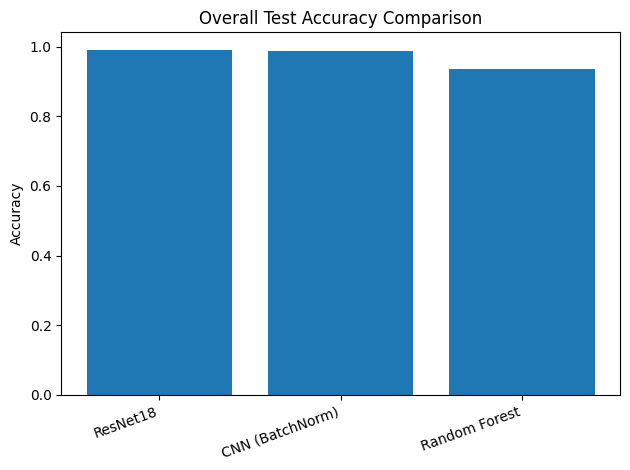

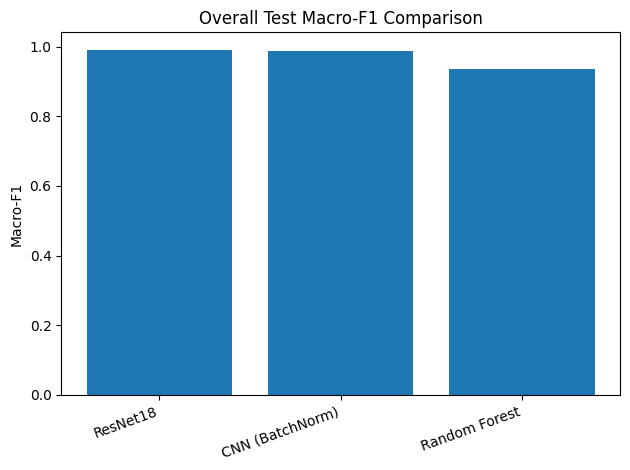

In [26]:
models = summary_df["Model"].tolist()
accs = summary_df["Test Accuracy"].tolist()
macros = summary_df["Test Macro-F1"].tolist()

plt.figure()
plt.bar(models, accs)
plt.title("Overall Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(models, macros)
plt.title("Overall Test Macro-F1 Comparison")
plt.ylabel("Macro-F1")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


In [29]:
print("=== CNN Report ===")
print(classification_report(cnn_res["y_true"], cnn_res["y_pred"], target_names=class_names, digits=4))

print("\n=== ResNet18 Report ===")
print(classification_report(resnet_res["y_true"], resnet_res["y_pred"], target_names=class_names, digits=4))

print("\n=== Random Forest Report ===")
print(classification_report(rf_res["y_true"], rf_res["y_pred"], target_names=class_names, digits=4))


=== CNN Report ===
              precision    recall  f1-score   support

    airplane     0.9891    0.9784    0.9837       463
      candle     0.9907    0.9953    0.9930       427
         car     0.9977    0.9864    0.9920       440
     diamond     0.9912    0.9825    0.9868       457
        fish     0.9642    0.9892    0.9765       463

    accuracy                         0.9862      2250
   macro avg     0.9866    0.9864    0.9864      2250
weighted avg     0.9864    0.9862    0.9862      2250


=== ResNet18 Report ===
              precision    recall  f1-score   support

    airplane     0.9978    0.9849    0.9913       463
      candle     0.9907    0.9977    0.9942       427
         car     0.9977    0.9932    0.9954       440
     diamond     0.9978    0.9891    0.9934       457
        fish     0.9746    0.9935    0.9840       463

    accuracy                         0.9916      2250
   macro avg     0.9917    0.9917    0.9917      2250
weighted avg     0.9917    0.9916

In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt

LOG_DIR = os.path.join(PROJECT_ROOT, "outputs", "training_logs")

print("Isi training_logs:", os.listdir(LOG_DIR))

cnn_log = os.path.join(LOG_DIR, "CNN_BatchNorm.csv")
resnet_log = os.path.join(LOG_DIR, "ResNet18.csv")

cnn_df = pd.read_csv(cnn_log)
resnet_df = pd.read_csv(resnet_log)

cnn_df.head(), resnet_df.head()


Isi training_logs: ['CNN_BatchNorm.csv', 'ResNet18.csv']


(   epoch  train_accuracy  val_accuracy  train_loss
 0      1       70.628571     88.844444    0.834506
 1      2       83.676190     92.711111    0.495111
 2      3       86.866667     93.333333    0.406619
 3      4       88.304762     92.755556    0.360098
 4      5       89.019048     89.022222    0.339810,
    epoch  train_accuracy  val_accuracy  train_loss
 0      1       82.228571     91.911111    0.507710
 1      2       92.133333     92.488889    0.243628
 2      3       93.800000     96.800000    0.196311
 3      4       94.638095     96.933333    0.170048
 4      5       94.904762     97.333333    0.154417)

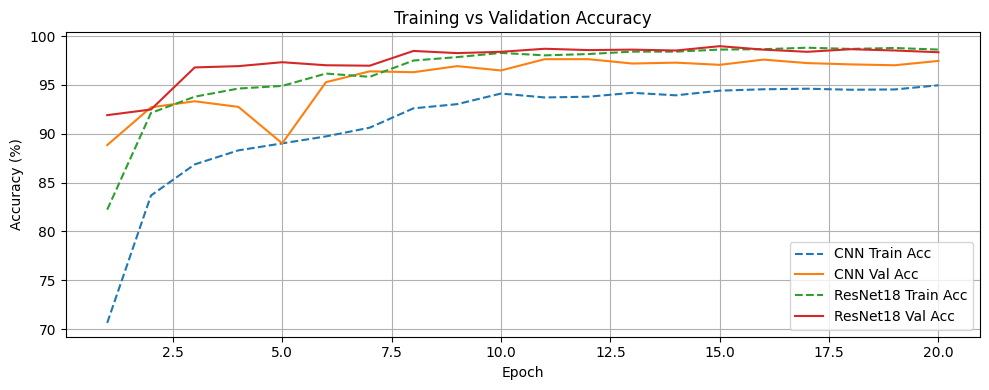

In [32]:
plt.figure(figsize=(10, 4))

# CNN
plt.plot(cnn_df["epoch"], cnn_df["train_accuracy"], label="CNN Train Acc", linestyle="--")
plt.plot(cnn_df["epoch"], cnn_df["val_accuracy"], label="CNN Val Acc")

# ResNet18
plt.plot(resnet_df["epoch"], resnet_df["train_accuracy"], label="ResNet18 Train Acc", linestyle="--")
plt.plot(resnet_df["epoch"], resnet_df["val_accuracy"], label="ResNet18 Val Acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
summary_training = pd.DataFrame([
    {
        "Model": "CNN (BatchNorm)",
        "Final Train Acc (%)": cnn_df["train_accuracy"].iloc[-1],
        "Final Val Acc (%)": cnn_df["val_accuracy"].iloc[-1],
        "Final Loss": cnn_df["train_loss"].iloc[-1],
    },
    {
        "Model": "ResNet18",
        "Final Train Acc (%)": resnet_df["train_accuracy"].iloc[-1],
        "Final Val Acc (%)": resnet_df["val_accuracy"].iloc[-1],
        "Final Loss": resnet_df["train_loss"].iloc[-1],
    }
])

summary_training


,Model,Final Train Acc (%),Final Val Acc (%),Final Loss
0,CNN (BatchNorm),94.971429,97.466667,0.178652
1,ResNet18,98.628571,98.355556,0.040273


In [34]:
import numpy as np
import matplotlib.pyplot as plt

def plot_f1_and_cm_grid(results_dict, class_names, suptitle="Models: F1-score & Confusion Matrix per Class"):
    """
    results_dict: dict
        contoh:
        {
          "CNN (BatchNorm)": {"per_class_f1": np.array([...]), "cm": np.array([[...],[...]])},
          "ResNet18": {"per_class_f1": np.array([...]), "cm": np.array([[...],[...]])},
          "Random Forest": {"per_class_f1": np.array([...]), "cm": np.array([[...],[...]])},
        }
    class_names: list[str]
    """
    model_names = list(results_dict.keys())
    n = len(model_names)

    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(14, 4*n))
    fig.suptitle(suptitle, fontsize=16, y=0.995)

    # Kalau n=1, axes shape beda; normalisasi
    if n == 1:
        axes = np.array([axes])

    for i, name in enumerate(model_names):
        r = results_dict[name]
        f1s = np.array(r["per_class_f1"])
        cm = np.array(r["cm"])

        # --- Left: F1 per class bar chart
        ax_bar = axes[i, 0]
        ax_bar.bar(class_names, f1s)
        ax_bar.set_ylim(0, 1.0)
        ax_bar.set_title(f"{name} - F1 per Class")
        ax_bar.set_ylabel("F1-score")
        ax_bar.tick_params(axis="x", rotation=20)

        # --- Right: Confusion matrix heatmap (matplotlib only)
        ax_cm = axes[i, 1]
        im = ax_cm.imshow(cm, interpolation="nearest")
        ax_cm.set_title(f"{name} - Confusion Matrix")
        ax_cm.set_xticks(np.arange(len(class_names)))
        ax_cm.set_yticks(np.arange(len(class_names)))
        ax_cm.set_xticklabels(class_names, rotation=20, ha="right")
        ax_cm.set_yticklabels(class_names)
        ax_cm.set_xlabel("Predicted")
        ax_cm.set_ylabel("True")

        # Annotate angka di setiap sel
        thresh = cm.max() * 0.6
        for y in range(cm.shape[0]):
            for x in range(cm.shape[1]):
                ax_cm.text(
                    x, y, int(cm[y, x]),
                    ha="center", va="center",
                    color="white" if cm[y, x] > thresh else "black",
                    fontsize=9
                )

        # Colorbar per-row (biar rapi)
        fig.colorbar(im, ax=ax_cm, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


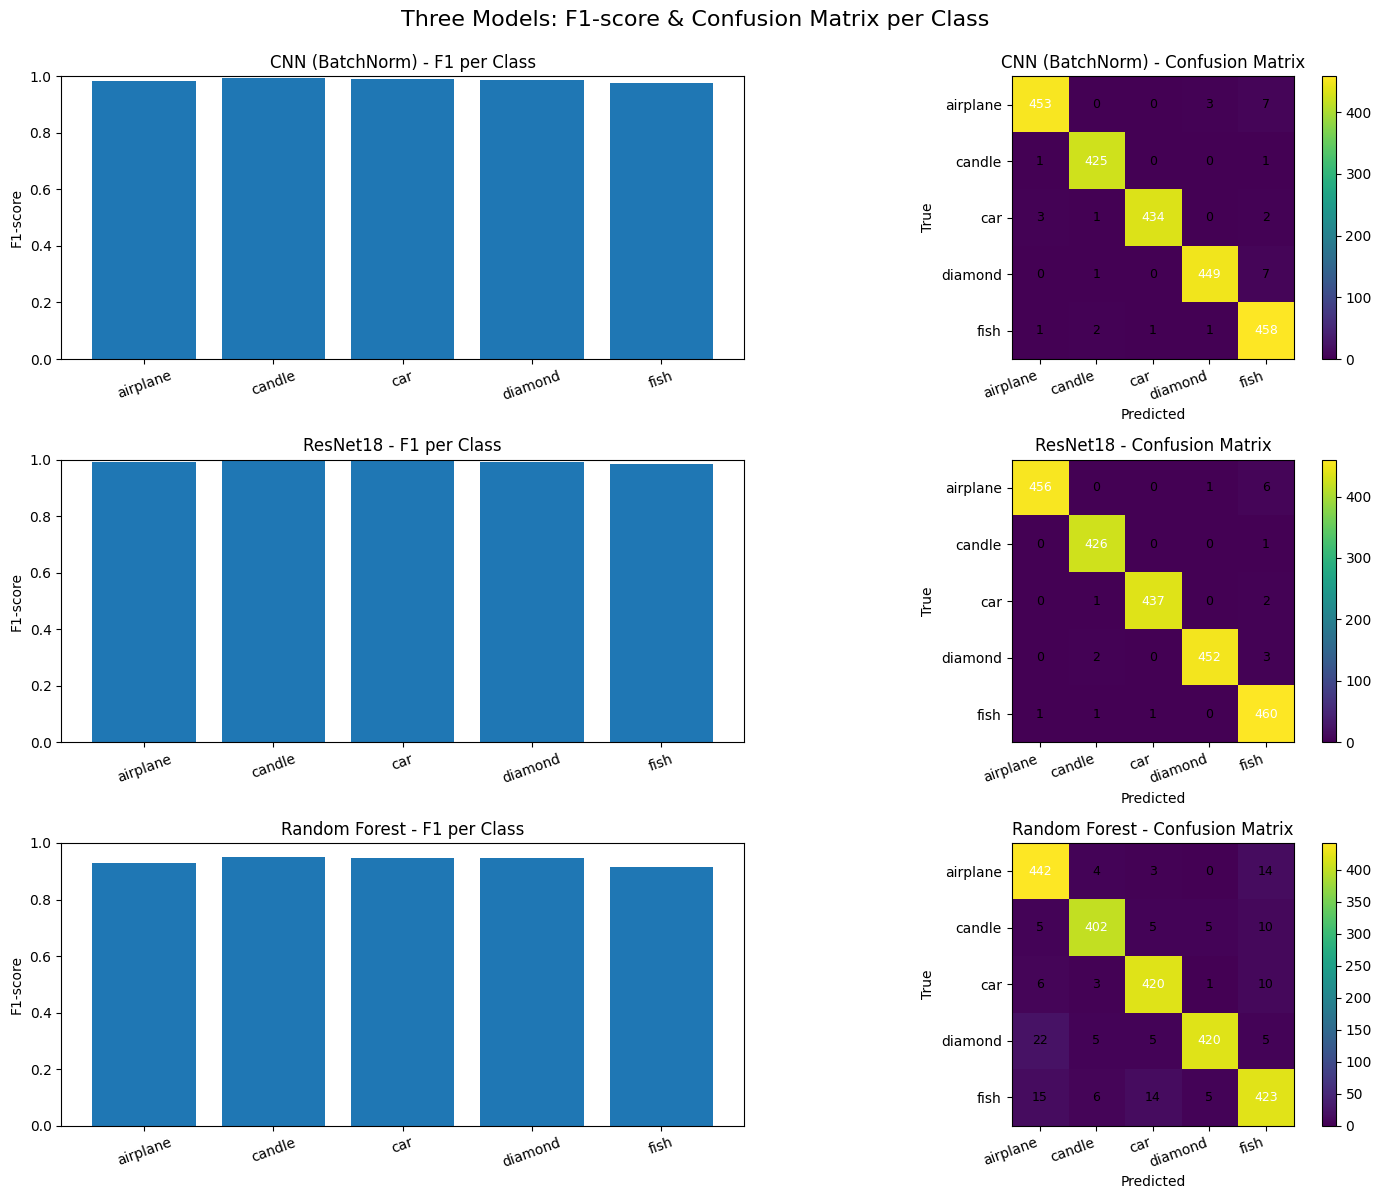

In [35]:
results_3 = {
    "CNN (BatchNorm)": {
        "per_class_f1": cnn_res["per_class_f1"],
        "cm": cnn_res["cm"],
    },
    "ResNet18": {
        "per_class_f1": resnet_res["per_class_f1"],
        "cm": resnet_res["cm"],
    },
    "Random Forest": {
        "per_class_f1": rf_res["per_class_f1"],
        "cm": rf_res["cm"],
    },
}

plot_f1_and_cm_grid(results_3, SELECTED_CLASSES, suptitle="Three Models: F1-score & Confusion Matrix per Class")
